# AlexNet

## 필요 라이브러리 불러오기

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import datetime, os
import tensorflow as tf


## 데이터 구성 현황
- 손상 컨테이너: 대각면 각도 사진만 추출 - 배경 있는 것, 없는 것 혼합 (2272장)
- 정상 컨테이너: 대각면 각도 사진만 추출 - 배경 있는 것, 없는 것 혼합 (2232장)
- 손상 사진 비율: 50.44%, 정상 사진 비율: 49.56%  
- Input데이터 사이즈 : (227 * 227 * 3)  

In [ ]:
X = np.load('./211026_AlexNet_input.npy')
Y = np.load('./211026_AlexNet_target.npy')

In [ ]:
print("인풋 세트의 배열형태: ", X.shape)
print("타겟 세트의 배열형태: ", Y.shape)

In [ ]:
x = np.unique(Y, return_counts=True)
damage_class = int(x[0][0])
normal_class = int(x[0][1])

damage_count = int(x[1][0])
normal_count = int(x[1][1])

print("손상 컨테이너: {}장".format(damage_count))
print("정상 컨테이너: {}장".format(normal_count))

total = damage_count + normal_count
d_ratio = damage_count/total*100
n_ratio = normal_count/total*100

print("손상 사진 비율: {0:.2f}%, 정상 사진 비율: {1:.2f}%".format(d_ratio, n_ratio))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)

In [ ]:
# 255로 나눠주어 전처리 시작
my_size = 227
X_train = X_train.reshape(X_train.shape[0], my_size, my_size, 3).astype('float32')/255
X_test = X_test.reshape(X_test.shape[0], my_size, my_size, 3).astype('float32')/255
print("훈련 세트 배열: ", X_train.shape)
print("테스트 세트 배열: ", X_test.shape)

## AlexNet 구조  
### Input layer  


*   Input image : 227x227x3

*   Conv2D : kernel_size를 설정해 두 개의 GPU에 각각 Convolution 해주고 활성화 시켜주기 위해 결과에 ReLU를 적용  

*   MaxPooling :  Convolution 한 결과에 3x3 Max pooling 과 LRN을 적용시켜 각 GPU에 Feature map을 생성한다  


### Fully connected layer  


*   Fully connected layer와 연결하기 위해 각 GPU의 6x6 Feature map 128개 (총 256개)를 Flatten 시킨다  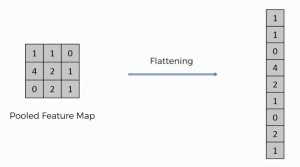


*   각 GPU의 6x6 Feature map 128개 (총 256개)를 모두 Faltten 하면 9216개의 Neuron을 가지는 Layer를 만들 수 있다. 이렇게 Flatten된 Layer는 4096개의 Neuron을 가지는 첫 번째 FC layer에 연결시킨다. 또한, 4096개의 Neuron을 가지는 첫 번째 FC layer와 마찬가지로 4096개의 Neuron을 가지는 두 번째 FC layer를 연결한다.  

## Output layer  


*   마지막으로 4096개의 Neuron을 가지는 두 번째 FC layer와 1개의 Neuron을 가지는 Output layer와 연결한다.이때 1개의 Neuron을 가지는 Output layer와 연결후 sigmoid 함수를 활요하여 결과를 출력한다











In [ ]:
model = Sequential()

model.add(Conv2D(96, kernel_size=(11,11),strides=4,
                    padding='valid',activation='relu',
                    input_shape=(227, 227, 3),
                    kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2),
                          padding='valid', data_format='channels_last'))
    
model.add(Conv2D(256, kernel_size=(5,5), strides=1,
                          padding='same', activation='relu',
                          kernel_initializer='he_normal'))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2),
                          padding='valid', data_format='channels_last'))
    
model.add(Conv2D(384, kernel_size=(3,3), strides=1,
                          padding='same', activation='relu',
                          kernel_initializer='he_normal'))
 
model.add(Conv2D(384, kernel_size=(3,3), strides=1,
                          padding='same', activation='relu',
                          kernel_initializer='he_normal'))
    
model.add(Conv2D(256, kernel_size=(3,3), strides=1,
                          padding='same', activation='relu',
                          kernel_initializer='he_normal'))
    
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2),
                          padding='valid', data_format='channels_last'))
    
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dense(1, activation='sigmoid')) 

model.summary()

model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])


## 딥러닝 실시

*   ModelCheckpoint로 hdf5파일에 최선의 데이터 저장(최소 val_loss)  
*   patience 설정후 EarlyStopping사용하여 조기종료(patience=10 일 경우 epoch가 10번 돌아가는동안 개선되지 않는다면 조기종료)  
*   AlexNet architecture 를 그대로 사용하여 딥러닝 후 교차검증 시행


In [ ]:
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath="./model/alexnet.hdf5"

checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
# 모델의 실행
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), 
                    epochs=50, batch_size=128, verbose=1, 
                    callbacks=[early_stopping_callback,checkpointer])

## 결과 출력

###  종료된 마지막 epoch기준 결과출력 

In [ ]:
# 테스트 세트에 적용해보기
print('\n Test Accurary: %.4f' % (model.evaluate(X_test, Y_test)[1]))

### hdf5에 저장된 최선의 결과 출력

In [ ]:
from tensorflow.keras.models import load_model
model2 = load_model('./model/alexnet.hdf5')

In [ ]:
# 테스트 세트에 적용해보기
print('\n Test Accurary: %.4f' % (model2.evaluate(X_test, Y_test)[1]))

## 검증 세트와 학습 세트간 손실값 오차 그래프

In [ ]:
y_vloss = history.history['val_loss']  # 검증 세트의 오차
y_loss = history.history['loss']  #  학습 세트의 오차

In [ ]:
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label='Test_Set_Loss')
plt.plot(x_len, y_loss, marker='^', c='green', label='Train_Set_Loss')
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()